In [1]:
import pandas as pd
import os
import seaborn as sns
import env
import wrangle_reg as acq
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
from pydataset import data
from sklearn.linear_model import LassoLars
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

### Acquire

In [2]:
df = acq.get_zillow_data()

csv file found and loaded


In [3]:
df.head()

,bathroomcnt,bedroomcnt,fips,garagecarcnt,yearbuilt,lotsizesquarefeet,taxvaluedollarcnt,transactiondate
0,3.5,4.0,6059.0,2.0,1998.0,4506.0,1023282.0,2017-01-01
1,1.0,2.0,6111.0,1.0,1967.0,12647.0,464000.0,2017-01-01
2,2.0,3.0,6059.0,2.0,1962.0,8432.0,564778.0,2017-01-01
3,3.0,4.0,6037.0,NaN,1970.0,13038.0,145143.0,2017-01-01
4,3.0,4.0,6037.0,NaN,1950.0,63000.0,773303.0,2017-01-01


In [4]:
df.describe()

,bathroomcnt,bedroomcnt,fips,garagecarcnt,yearbuilt,lotsizesquarefeet,taxvaluedollarcnt
count,52442.000000,52442.000000,52442.000000,18015.000000,52326.000000,5.207300e+04,5.244100e+04
mean,2.299397,3.300675,6049.131917,1.948987,1963.393820,1.133952e+04,5.296830e+05
std,1.022764,0.949086,21.028933,0.549944,23.133355,8.674680e+04,7.518883e+05
min,0.000000,0.000000,6037.000000,0.000000,1878.000000,2.360000e+02,1.000000e+03
25%,2.000000,3.000000,6037.000000,2.000000,1950.000000,5.583000e+03,1.937500e+05
50%,2.000000,3.000000,6037.000000,2.000000,1961.000000,6.840000e+03,3.736120e+05
75%,3.000000,4.000000,6059.000000,2.000000,1979.000000,8.798000e+03,6.193010e+05
max,18.000000,14.000000,6111.000000,14.000000,2016.000000,6.971010e+06,4.906124e+07


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathroomcnt        52442 non-null  float64
 1   bedroomcnt         52442 non-null  float64
 2   fips               52442 non-null  float64
 3   garagecarcnt       18015 non-null  float64
 4   yearbuilt          52326 non-null  float64
 5   lotsizesquarefeet  52073 non-null  float64
 6   taxvaluedollarcnt  52441 non-null  float64
 7   transactiondate    52442 non-null  object 
dtypes: float64(7), object(1)
memory usage: 3.6+ MB


### Prepare

In [6]:
df = acq.prep_zillow(df)

In [7]:
df.head()

,bathrooms,bedrooms,county,car garage,yr built,sq ft,value,date
0,3.5,4.0,Orange County,2.0,1998.0,4506.0,1023282.0,2017-01-01
1,1.0,2.0,Ventura,1.0,1967.0,12647.0,464000.0,2017-01-01
2,2.0,3.0,Orange County,2.0,1962.0,8432.0,564778.0,2017-01-01
8,2.5,3.0,Orange County,2.0,1980.0,1199.0,319668.0,2017-01-02
9,2.5,3.0,Ventura,2.0,2004.0,3445.0,198054.0,2017-01-02


In [8]:
def drop_columns(df, columns_to_drop):
    df = df.drop(columns=columns_to_drop)
    return df

columns_to_drop = ['yr built', 'date', 'car garage', 'date', 'county']


df = drop_columns(df, columns_to_drop)

In [9]:
df.head()

,bathrooms,bedrooms,sq ft,value
0,3.5,4.0,4506.0,1023282.0
1,1.0,2.0,12647.0,464000.0
2,2.0,3.0,8432.0,564778.0
8,2.5,3.0,1199.0,319668.0
9,2.5,3.0,3445.0,198054.0


In [10]:
df = acq.remove_outliers(df, threshold=3)

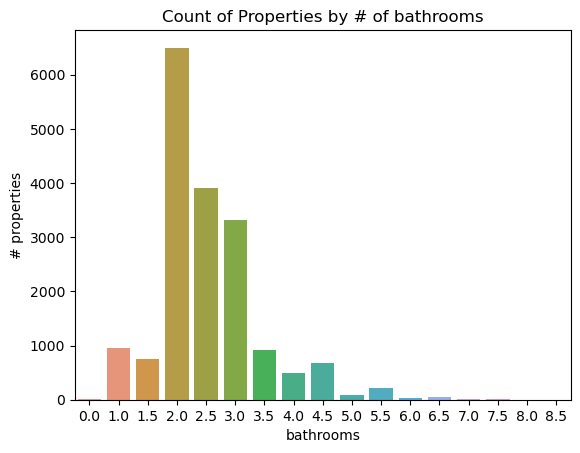

In [11]:
sns.countplot(data=df, x=df.bathrooms)
plt.xlabel('bathrooms')
plt.ylabel('# properties')
plt.title('Count of Properties by # of bathrooms')
plt.show()

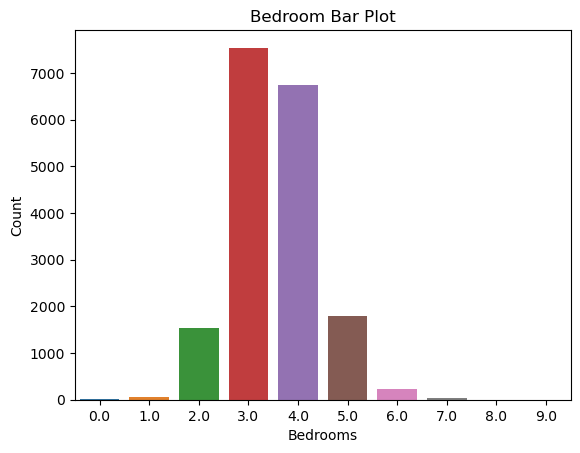

In [12]:
sns.countplot(data=df, x='bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.title('Bedroom Bar Plot')
plt.show()

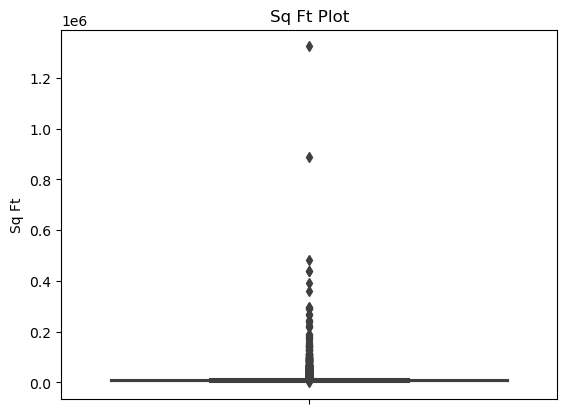

In [13]:
sns.boxplot(data=df, y='sq ft')
plt.ylabel('Sq Ft')
plt.title('Sq Ft Plot')
plt.show()

### Explore

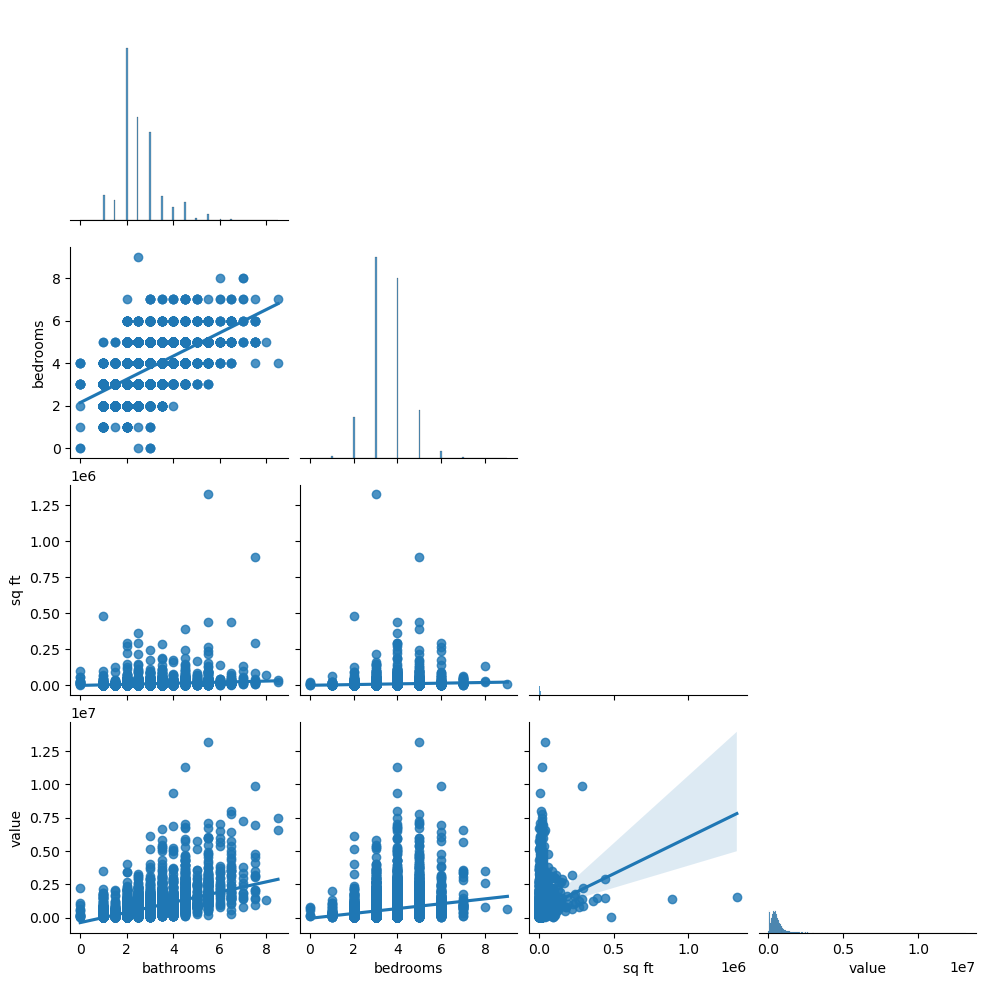

In [14]:
sns.pairplot(df, kind='reg', corner=True)

In [15]:
train, validate, test = acq.train_split_data(df)


    train -> (10052, 4)
    validate -> (4308, 4)
    test -> (3590, 4)


In [16]:
train.isnull().sum()

bathrooms    0
bedrooms     0
sq ft        0
value        0
dtype: int64

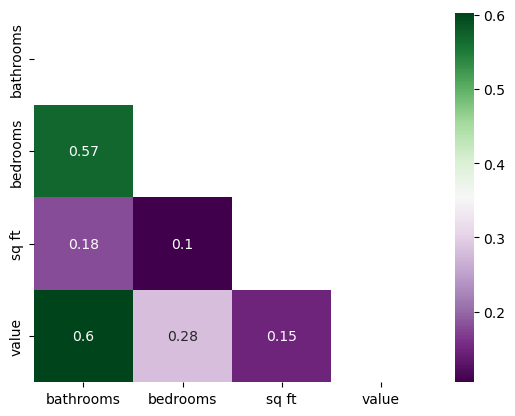

In [17]:
sns.heatmap(train.corr(), cmap='PRGn', annot=True,
           mask=np.triu(train.corr()))
plt.show()

In [18]:
#Split dataset into two components
X, Y = acq.split_data_axis(df)

# splitting data into train, validate, and test
X_train, X_validate, X_test, y_train, y_validate, y_test = acq.train_validate_test_split(X, Y)


    X_train -> (10052, 3)'
    X_validate -> (4308, 3)'
    X_test -> (3590, 3)


In [19]:
y_train.head()

,value
46353,328628.0
48891,534461.0
39038,706493.0
15156,47718.0
42958,576000.0


### Summary of exploration: 

##### All features seem to have a week correlation with the target variable except for bathroom count which had a corr value of .6

In [20]:
#Established Baseline

baseline = y_train.mean()
baseline

value    584945.767409
dtype: float64

In [21]:
#RMSE chosen as evaluation metric 
baseline_array = np.repeat(baseline, len(y_train))
baseline_array[:5]

value    584945.767409
value    584945.767409
value    584945.767409
value    584945.767409
value    584945.767409
dtype: float64

In [22]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

Root Mean Squared Error takes the error between the predicted line/value and the actual values/line, finds the mean difference/error, and gets the square root.

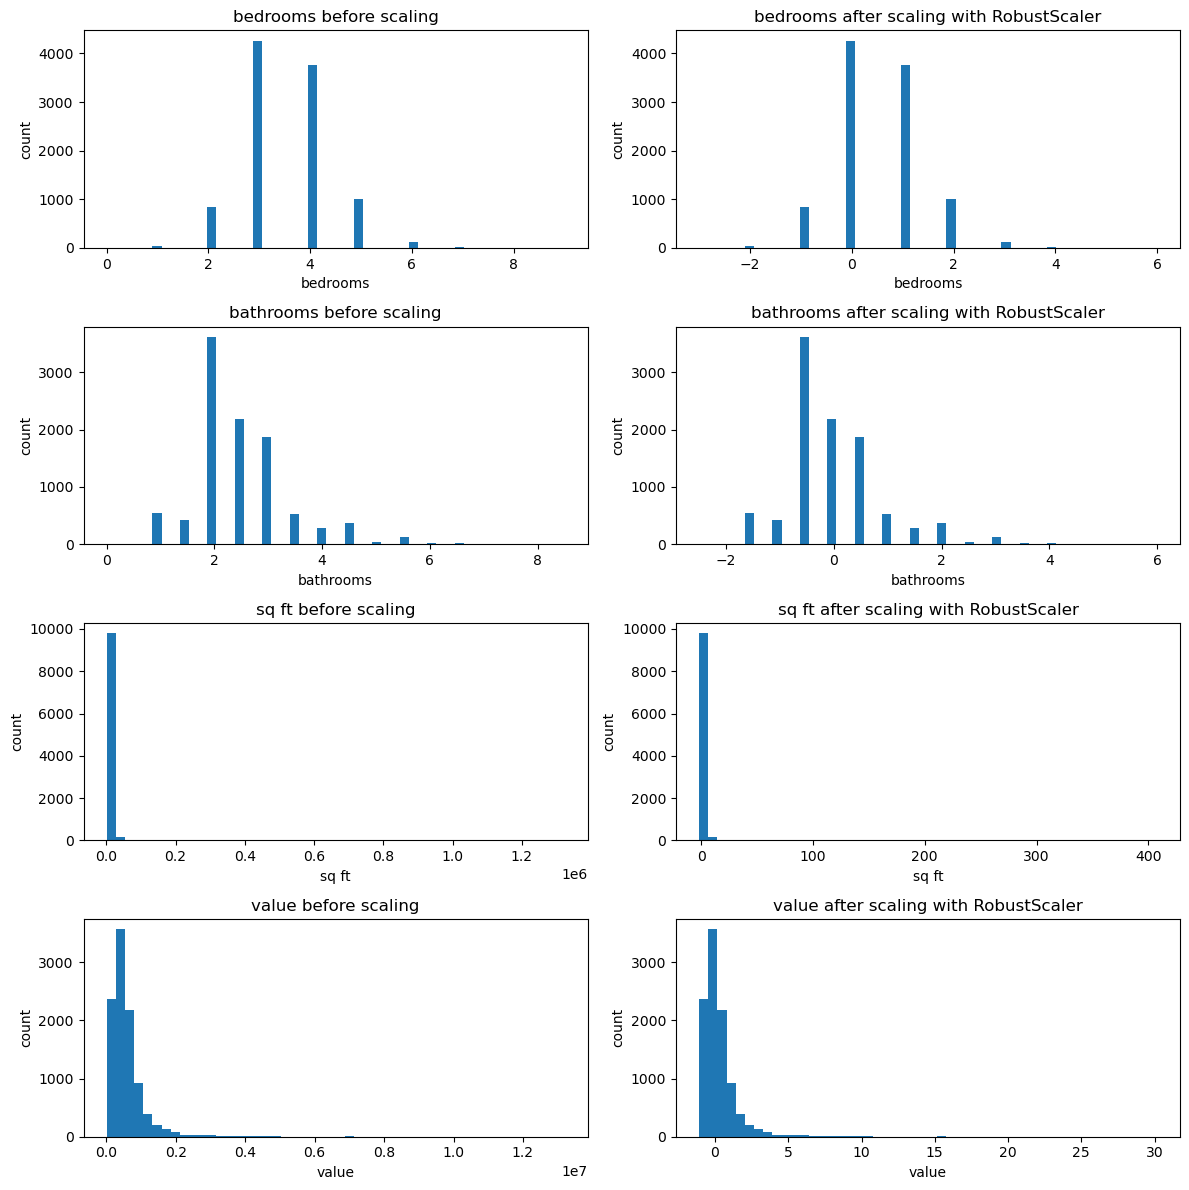

In [23]:
# Values Scaled

to_scale = ['bedrooms','bathrooms','sq ft']
acq.visualize_scaler(scaler=RobustScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)


In [24]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=1)

#fit it
rfe.fit(X_train, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train)

#use it on validate
X_val_rfe = rfe.transform(X_validate)

#use it on test
X_test_rfe = rfe.transform(X_test)

In [25]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['bathrooms']


### On Train

In [26]:
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)
pred_test_lrl = lr1.predict(X_test_rfe)

In [27]:
pred_lr1[:5]

array([[762699.68761548],
       [382330.89444661],
       [382330.89444661],
       [192146.49786217],
       [382330.89444661]])

In [28]:
#train
metrics_reg(y_train, pred_lr1)

(457631.4969329815, 0.36295398070092877)

In [40]:
baseline = y_train.mean()
baseline

value    584945.767409
dtype: float64

In [41]:
baseline_array = np.repeat(baseline, len(y_train))
baseline_array[:5]

value    584945.767409
value    584945.767409
value    584945.767409
value    584945.767409
value    584945.767409
dtype: float64

In [29]:
rmse, r2 = acq.metrics_reg(y_train, baseline_array)
rmse, r2

(573364.1097630578, 0.0)

In [30]:
lr1.intercept_

array([-378406.69189113])

In [31]:
lr1.coef_

array([[380368.79316887]])

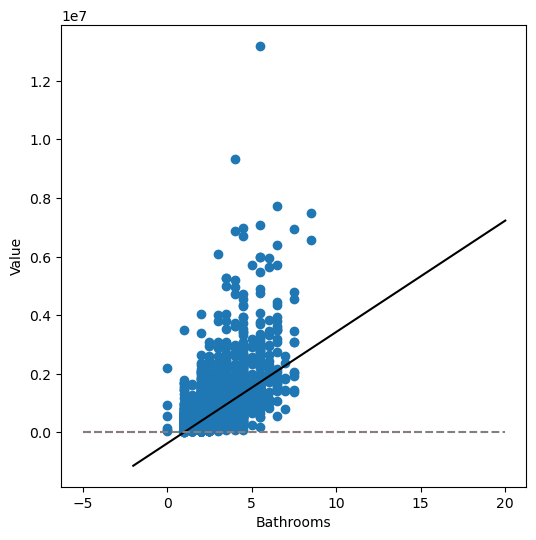

In [32]:
plt.figure(figsize=(6, 6))

plt.scatter(train.bathrooms, train.value)

#build prediction line from intercept and slope
x_val = np.array([-2, 20]).reshape(-1, 1)
plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='black')

#intercept line
plt.hlines(22, -5, 15, ls=':', color='red')  

#(0,0) axis
plt.hlines(0, -5, 20, ls='--', color='grey')
plt.vlines(0, -10, 20, ls='--', color='grey')
 
plt.xlabel('Bathrooms')
plt.ylabel('Value')
plt.show()

In [33]:
pred_val_lr1[:5]

array([[382330.89444661],
       [762699.68761548],
       [572515.29103104],
       [382330.89444661],
       [382330.89444661]])

In [34]:
#train
metrics_reg(y_validate, pred_val_lr1)

(433740.0283650024, 0.3559416302994872)

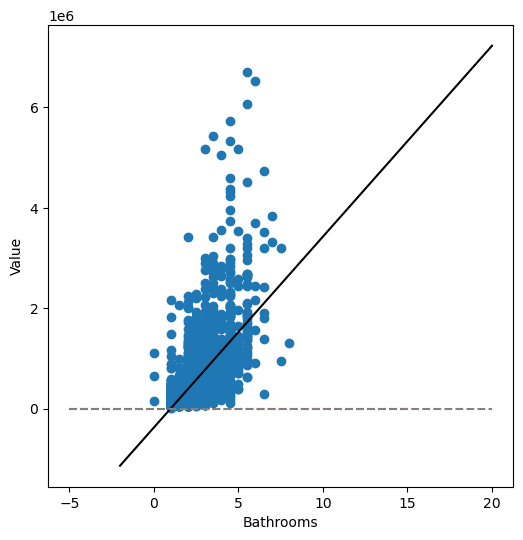

In [38]:
plt.figure(figsize=(6, 6))

plt.scatter(validate.bathrooms, validate.value)

#build prediction line from intercept and slope
x_val = np.array([-2, 20]).reshape(-1, 1)
plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='black')

#intercept line
plt.hlines(22, -5, 15, ls=':', color='red')  

#(0,0) axis
plt.hlines(0, -5, 20, ls='--', color='grey')
plt.vlines(0, -10, 20, ls='--', color='grey')
 
plt.xlabel('Bathrooms')
plt.ylabel('Value')
plt.show()

In [35]:
pred_test_lrl[:5]

array([[ 572515.29103104],
       [ 382330.89444661],
       [ 382330.89444661],
       [1143068.48078434],
       [ 762699.68761548]])

In [37]:
metrics_reg(y_test, pred_test_lrl)

(508743.81191819755, 0.3425715206844927)

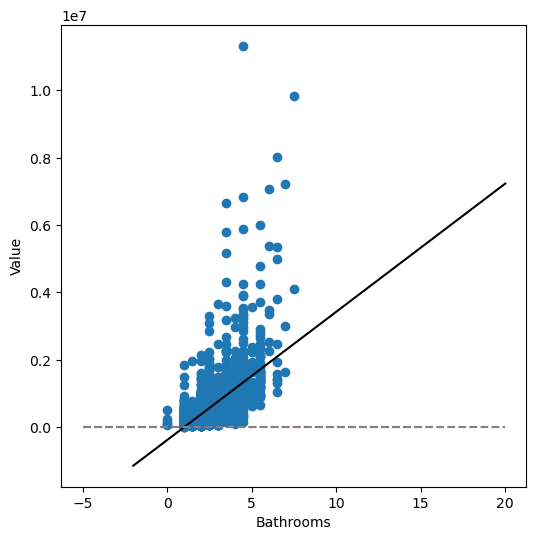

In [39]:
plt.figure(figsize=(6, 6))

plt.scatter(test.bathrooms, test.value)

#build prediction line from intercept and slope
x_val = np.array([-2, 20]).reshape(-1, 1)
plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='black')

#intercept line
plt.hlines(22, -5, 15, ls=':', color='red')  

#(0,0) axis
plt.hlines(0, -5, 20, ls='--', color='grey')
plt.vlines(0, -10, 20, ls='--', color='grey')
 
plt.xlabel('Bathrooms')
plt.ylabel('Value')
plt.show()